In [1]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sb
#from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#Load the Dataset to the DataFrame
df = pd.read_csv('C:/Users/Hp/Downloads/IMDB Dataset2.csv')

In [3]:
#Display the head of the DataFrame
df.head()

,id,Review
0,1,One of the other reviewers has mentioned that ...
1,2,A wonderful little production. <br /><br />The...
2,3,I thought this was a wonderful way to spend ti...
3,4,Basically there's a family where a little boy ...
4,5,"Petter Mattei's ""Love in the Time of Money"" is..."


In [4]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#clean Text
def cleanText(text):
    text = text.lower()
    text = text.translate(string.punctuation)
    text = text.replace('+', ' ')
    text = text.replace(',', '')
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = re.sub(r'https?:\/\/\S+','',text) #Remove the hyperlink
    text = emoji_pattern.sub(r'',text) #Remove emoji
    text = strip_html(text) #Removing html strips
    text = re.sub(r'[^a-zA-z0-9\s]','',text) #remove special character
    
    
    #tokens = nltk.word_tokenize(text)
    
    return text
    

In [5]:
df['Review']=df['Review'].apply(cleanText)

In [6]:
df.head()

,id,Review
0,1,one of the other reviewers has mentioned that ...
1,2,a wonderful little production the filming tech...
2,3,i thought this was a wonderful way to spend ti...
3,4,basically theres a family where a little boy j...
4,5,petter matteis love in the time of money is a ...


In [7]:
#Subjectivity range [0,1]
#The higher subjectivity means that the text contains personal 
#opinion rather than factual information
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Polarity range [-1,1]
#-1 = negative sentiment
#1 = positive sentiment
def getPolarity(text):
    
    return TextBlob(text).sentiment.polarity   

def getSentiment(score):
    
    if score == 0:
        return 'Neutral'
    elif score < 0:
        return 'Negative'
    else:
        return 'Positive'


In [8]:
df['Subjectivity Score'] = df['Review'].apply(getSubjectivity)
df['Polarity Score'] = df['Review'].apply(getPolarity)
df['Sentiment'] = df['Polarity Score'].apply(getSentiment)

In [9]:
df.head()

,id,Review,Subjectivity Score,Polarity Score,Sentiment
0,1,one of the other reviewers has mentioned that ...,0.490369,0.023433,Positive
1,2,a wonderful little production the filming tech...,0.559343,0.111490,Positive
2,3,i thought this was a wonderful way to spend ti...,0.640769,0.346324,Positive
3,4,basically theres a family where a little boy j...,0.454167,-0.060937,Negative
4,5,petter matteis love in the time of money is a ...,0.452916,0.217952,Positive


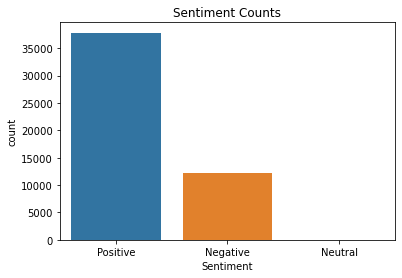

In [10]:
#Visualize categories
sb.countplot(df["Sentiment"])
plt.title("Sentiment Counts")
plt.show()

In [11]:
# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder

# Initialize the Label Encoder.
encoder = LabelEncoder()

# Encode the categories
df['Sentiment_enc'] = encoder.fit_transform(df['Sentiment'])

df.head()

,id,Review,Subjectivity Score,Polarity Score,Sentiment,Sentiment_enc
0,1,one of the other reviewers has mentioned that ...,0.490369,0.023433,Positive,2
1,2,a wonderful little production the filming tech...,0.559343,0.111490,Positive,2
2,3,i thought this was a wonderful way to spend ti...,0.640769,0.346324,Positive,2
3,4,basically theres a family where a little boy j...,0.454167,-0.060937,Negative,0
4,5,petter matteis love in the time of money is a ...,0.452916,0.217952,Positive,2


In [12]:
#split dataset in features and target variable
X = df['Review']
y = df['Sentiment_enc']

# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 34)

In [13]:
# check the shape of X_train and X_test
X_train.shape, X_test.shape

((35000,), (15000,))

In [14]:
X_train.head()

33832    when i first saw before night falls javier bar...
29125    please why on earth did bava had to add insult...
3038     i really love this movie  i saw it for the fir...
16014    predictable unmotivated pointless caricatures ...
11262    not confusing in the sense that gee this movie...
Name: Review, dtype: object

In [15]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the Multinomial Naive Bayes (MNB) accuracy score
print("MNB Accuracy:", nb.score(tfidf_test, y_test))
print("MNB Accuracy percentage:", round((nb.score(tfidf_test, y_test)*100),2), "%")

MNB Accuracy: 0.7561333333333333
MNB Accuracy percentage: 75.61 %


In [16]:
# Predict the labels
y_pred = nb.predict(tfidf_test)

set(y_test) - set(y_pred)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)


Confusion Matrix

[[    0     0  3647]
 [    0     0    11]
 [    0     0 11342]]


Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3647
           1       0.00      0.00      0.00        11
           2       0.76      1.00      0.86     11342

    accuracy                           0.76     15000
   macro avg       0.25      0.33      0.29     15000
weighted avg       0.57      0.76      0.65     15000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression
lr = LogisticRegression()

# Fit the model
lr.fit(tfidf_train, y_train)

# Print the accuracy score
print("Logistic Regression Accuracy:", lr.score(tfidf_test, y_test))
print("Logistic Regression Accuracy percentage:", round((lr.score(tfidf_test, y_test)*100),2), "%")

Logistic Regression Accuracy: 0.9096
Logistic Regression Accuracy percentage: 90.96 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# Predict the labels
y_pred = lr.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)


Confusion Matrix

[[ 2536     0  1111]
 [    5     0     6]
 [  234     0 11108]]


Classification Report

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      3647
           1       0.00      0.00      0.00        11
           2       0.91      0.98      0.94     11342

    accuracy                           0.91     15000
   macro avg       0.61      0.56      0.58     15000
weighted avg       0.91      0.91      0.90     15000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.linear_model import SGDClassifier

# Initialize the SVM
svm = SGDClassifier()

# Fit the model
svm.fit(tfidf_train, y_train)

# Print the SVM accuracy score
print("SVM Accuracy:", svm.score(tfidf_test, y_test))
print("SVM Accuracy percentage:", round((svm.score(tfidf_test, y_test)*100),2), "%")

SVM Accuracy: 0.8864
SVM Accuracy percentage: 88.64 %


In [20]:
# Predict the labels
y_pred = svm.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)


Confusion Matrix

[[ 2126     0  1521]
 [    4     0     7]
 [  172     0 11170]]


Classification Report

              precision    recall  f1-score   support

           0       0.92      0.58      0.71      3647
           1       0.00      0.00      0.00        11
           2       0.88      0.98      0.93     11342

    accuracy                           0.89     15000
   macro avg       0.60      0.52      0.55     15000
weighted avg       0.89      0.89      0.88     15000



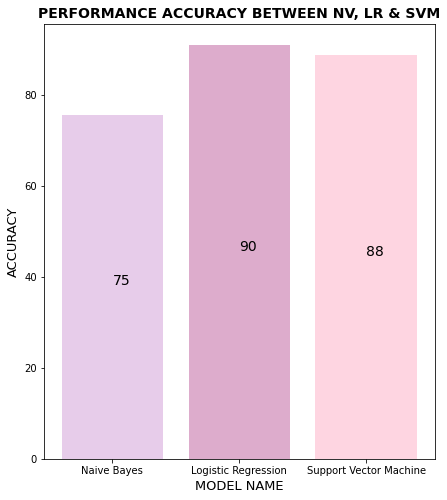

In [26]:
accuracy_scores = [round((nb.score(tfidf_test, y_test)*100),2), round((lr.score(tfidf_test, y_test)*100),2), round((svm.score(tfidf_test, y_test)*100),2)]
model_name = ['Naive Bayes', 'Logistic Regression', 'Support Vector Machine']

total_bar = np.arange(len(model_name))
color = ['#E0BBE4', '#D291BC', '#FEC8D8']

fig, ax = plt.subplots(figsize=(7, 8))
bar = plt.bar(model_name, accuracy_scores, align = 'center', alpha = .75, color = color)
plt.xticks(total_bar, model_name)
plt.ylabel('ACCURACY', fontsize = 13)
plt.xlabel('MODEL NAME', fontsize = 13)
plt.title('PERFORMANCE ACCURACY BETWEEN NV, LR & SVM', fontsize = 14, fontweight = 'bold')

# Data label 
def autolabel(bar):
    for bar in bar:
        height = int(bar.get_height())
        ax.text(bar.get_x() + .4, .5 * height,
                height, va = 'bottom',
                fontsize = 14)
        
autolabel(bar)
plt.show()